<a href="https://colab.research.google.com/github/thePegasusai/stripedhyena/blob/main/striped_hyena_enhanced_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StripedHyena Neural Style Transfer - Enhanced TPU Version

This notebook provides an enhanced implementation of neural style transfer using the StripedHyena architecture developed by Liquid AI. The implementation is specifically optimized for Google Colab's TPU environment.

## What's New in This Enhanced Version

- **Detailed Architecture Explanations**: In-depth explanations of the StripedHyena architecture components
- **Interactive Examples**: User-friendly interface for experimenting with different content and style images
- **Custom Dataset Training**: Support for training on your own dataset of images
- **TPU Optimizations**: Performance enhancements specifically for Google Colab's TPU environment
- **Visualization Tools**: Better visualization of the style transfer process and results
- **Hyperparameter Tuning**: Interactive controls for adjusting style transfer parameters

## Table of Contents

1. [Setup and Dependencies](#setup)
2. [StripedHyena Architecture Overview](#architecture)
3. [Model Implementation](#implementation)
4. [Basic Style Transfer Demo](#basic_demo)
5. [Advanced Style Transfer with Parameter Tuning](#advanced_demo)
6. [Training on Custom Datasets](#custom_training)
7. [Performance Analysis: TPU vs. CPU vs. GPU](#performance)
8. [Exporting Your Model](#export)

## 1. Setup and Dependencies <a name="setup"></a>

First, let's set up our environment and install the necessary dependencies. This notebook is designed to work with TPUs, but will fall back to GPU or CPU if TPUs are not available.

In [ ]:
import os
import sys
import torch

def check_tpu_availability():
    """Check if TPU is available and properly configured"""

    # Method 1: Check environment variables
    tpu_address = os.environ.get('COLAB_TPU_ADDR')
    if tpu_address:
        print(f"TPU address found: {tpu_address}")
        IS_TPU_AVAILABLE = True
    else:
        print("COLAB_TPU_ADDR environment variable not found")
        IS_TPU_AVAILABLE = False

    # Method 2: Try to import and detect TPU using torch_xla
    try:
        import torch_xla
        import torch_xla.core.xla_model as xm

        # Check if XLA devices are available
        device = xm.xla_device()
        print(f"XLA device detected: {device}")

        # Get TPU device count (using new API to avoid deprecation warning)
        try:
            import torch_xla.runtime as xr
            device_count = xr.world_size()
        except (ImportError, AttributeError):
            # Fallback to deprecated method if new one isn't available
            device_count = xm.xrt_world_size()
        print(f"Number of TPU cores: {device_count}")

        if device_count > 0:
            IS_TPU_AVAILABLE = True
            print("✅ TPU is available and accessible via torch_xla!")
        else:
            IS_TPU_AVAILABLE = False
            print("❌ TPU cores not detected")

    except ImportError:
        print("torch_xla not installed - installing now...")
        # Install torch_xla for TPU support
        os.system('pip install torch_xla[tpu] -f https://storage.googleapis.com/libtpu-releases/index.html')
        print("Please restart runtime after installation")
        IS_TPU_AVAILABLE = False

    except Exception as e:
        print(f"Error accessing TPU via torch_xla: {e}")
        IS_TPU_AVAILABLE = False

    return IS_TPU_AVAILABLE

def check_gpu_availability():
    """Check GPU availability"""
    if torch.cuda.is_available():
        gpu_count = torch.cuda.device_count()
        gpu_name = torch.cuda.get_device_name(0)
        print(f"✅ GPU is available: {gpu_name}")
        print(f"Number of GPUs: {gpu_count}")
        return True
    else:
        print("❌ GPU is not available")
        return False

def setup_device():
    """Setup the appropriate device for training"""

    print("=" * 50)
    print("DEVICE DETECTION")
    print("=" * 50)

    # Check TPU first
    tpu_available = check_tpu_availability()

    if tpu_available:
        try:
            import torch_xla.core.xla_model as xm
            device = xm.xla_device()
            print(f"🚀 Using TPU: {device}")
            return device, "tpu"
        except:
            print("Failed to initialize TPU device")

    # Check GPU if TPU not available
    gpu_available = check_gpu_availability()

    if gpu_available:
        device = torch.device("cuda")
        print(f"🚀 Using GPU: {device}")
        return device, "gpu"

    # Fallback to CPU
    device = torch.device("cpu")
    print("🚀 Using CPU")
    return device, "cpu"

# Run the detection
if __name__ == "__main__":
    device, device_type = setup_device()

    print("\n" + "=" * 50)
    print("ADDITIONAL TPU SETUP (if using TPU)")
    print("=" * 50)

    if device_type == "tpu":
        print("""
To use TPU effectively in your training loop, remember to:

1. Move your model to TPU:
   model = model.to(device)

2. Use xm.optimizer_step() instead of optimizer.step():
   import torch_xla.core.xla_model as xm
   xm.optimizer_step(optimizer)

3. Use xm.mark_step() for gradient synchronization:
   xm.mark_step()

4. For multi-core TPU training, use xm.spawn():
   import torch_xla.distributed.parallel_loader as pl
        """)

DEVICE DETECTION
COLAB_TPU_ADDR environment variable not found
XLA device detected: xla:0
Number of TPU cores: 1
✅ TPU is available and accessible via torch_xla!
🚀 Using TPU: xla:0

ADDITIONAL TPU SETUP (if using TPU)

To use TPU effectively in your training loop, remember to:

1. Move your model to TPU:
   model = model.to(device)

2. Use xm.optimizer_step() instead of optimizer.step():
   import torch_xla.core.xla_model as xm
   xm.optimizer_step(optimizer)

3. Use xm.mark_step() for gradient synchronization:
   xm.mark_step()

4. For multi-core TPU training, use xm.spawn():
   import torch_xla.distributed.parallel_loader as pl
        


In [ ]:
import torch
import torch_xla.core.xla_model as xm
import time

device = xm.xla_device()
print(f"Using device: {device}")

# Test computation on TPU
print("\n🧪 Testing TPU computation...")
start_time = time.time()

# Create tensors on TPU
x = torch.randn(1000, 1000).to(device)
y = torch.randn(1000, 1000).to(device)

# Perform matrix multiplication
result = torch.matmul(x, y)

# Important: Mark step to sync computation
xm.mark_step()

end_time = time.time()
print(f"✅ Matrix multiplication completed in {end_time - start_time:.4f} seconds")
print(f"Result shape: {result.shape}")
print(f"Result device: {result.device}")

Using device: xla:0

🧪 Testing TPU computation...
✅ Matrix multiplication completed in 0.8399 seconds
Result shape: torch.Size([1000, 1000])
Result device: xla:0


In [ ]:
# Install required packages
!pip install torch torchvision matplotlib numpy pillow tqdm requests

# If TPU is available, install PyTorch XLA
if IS_TPU_AVAILABLE:
    !pip install cloud-tpu-client==0.10 torch_xla[tpu]==2.0 -f https://storage.googleapis.com/libtpu-releases/index.html

NameError: name 'IS_TPU_AVAILABLE' is not defined

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import time

# Check if TPU is available (you'll need to define IS_TPU_AVAILABLE or check differently)
try:
    import torch_xla.core.xla_model as xm
    IS_TPU_AVAILABLE = True
except ImportError:
    IS_TPU_AVAILABLE = False

# Set up device
if IS_TPU_AVAILABLE:
    try:
        import torch_xla.core.xla_model as xm
        device = xm.xla_device()
        print(f"Using TPU: {device}")
    except Exception as e:
        print(f"TPU initialization failed: {e}")
        device = torch.device("cpu")
        print("Falling back to CPU")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Additional setup for different devices
if device.type == 'cuda':
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Device set to: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

# Test tensor creation on the device
test_tensor = torch.randn(3, 3).to(device)
print(f"Test tensor shape: {test_tensor.shape}")
print(f"Test tensor device: {test_tensor.device}")

Using TPU: xla:0
Device set to: xla:0
PyTorch version: 2.6.0+cpu
Torchvision version: 0.21.0+cpu
Test tensor shape: torch.Size([3, 3])
Test tensor device: xla:0


## 2. StripedHyena Architecture Overview <a name="architecture"></a>

The StripedHyena architecture, developed by Liquid AI, is a hybrid neural network architecture that combines rotary (grouped) attention with gated convolutions. This section provides a detailed explanation of the architecture and its components.

### 2.1 Key Components of StripedHyena

#### Rotary Positional Embeddings
Rotary positional embeddings (RoPE) encode spatial information, allowing the model to understand the relative positions of features in both content and style images. This is crucial for maintaining spatial coherence in the stylized output.

```
def apply_rotary_embeddings(x, freqs):
    # x: [batch, seq_len, dim]
    # freqs: [seq_len, dim/2]
    seq_len = x.shape[1]
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    freqs = freqs[:seq_len]
    freqs = torch.view_as_complex(freqs.reshape(*freqs.shape[:-1], -1, 2))
    x_rotated = x_complex * freqs
    x_rotated = torch.view_as_real(x_rotated).flatten(-2)
    return x_rotated.type_as(x)
```

#### Gated Convolutions
The architecture employs gated convolutions that adaptively control information flow, allowing the model to selectively apply style features based on content characteristics. This results in more natural-looking style transfers that preserve important content details.

```
class GatedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels*2, kernel_size, stride, padding)
        
    def forward(self, x):
        # Split channels into two parts
        h = self.conv(x)
        a, b = torch.chunk(h, 2, dim=1)
        # Apply gating mechanism
        return a * torch.sigmoid(b)
```

#### Hybrid Attention Mechanism
StripedHyena combines local processing (through convolutions) with global context awareness (through attention mechanisms), creating a hybrid approach that captures both fine details and overall style patterns. This hybrid design is particularly effective for style transfer tasks.

### 2.2 Advantages for Neural Style Transfer

1. **Memory Efficiency**: Processes high-resolution images with significantly lower memory requirements than traditional Transformer models.
2. **Linear Scaling**: Computational complexity scales linearly with image size instead of quadratically.
3. **Long-range Dependencies**: Efficiently captures relationships between distant parts of the image.
4. **Adaptive Processing**: Intelligently applies style based on content characteristics.
5. **TPU Compatibility**: Architecture is well-suited for TPU acceleration.

### 2.3 Adaptation for 2D Images

The original StripedHyena architecture was designed for 1D sequence processing. For neural style transfer, we adapt it to 2D image processing by:

1. Converting 2D images to sequences by flattening spatial dimensions
2. Applying StripedHyena processing
3. Reshaping back to 2D for convolutional processing
4. Using skip connections to preserve spatial information

This approach allows us to leverage the strengths of the StripedHyena architecture while maintaining the spatial structure necessary for image processing.

## 3. Model Implementation <a name="implementation"></a>

Now, let's implement the StripedHyena neural style transfer model. We'll start with the core components and then build the complete model.

In [ ]:
# Rotary Positional Embeddings implementation
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class RotaryEmbedding(nn.Module):
    def __init__(self, dim, base=10000):
        super().__init__()
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)
        self.seq_len_cached = None
        self.cos_cached = None
        self.sin_cached = None

    def forward(self, x, seq_len=None):
        if seq_len is None:
            seq_len = x.shape[1]

        if seq_len != self.seq_len_cached:
            self.seq_len_cached = seq_len
            t = torch.arange(seq_len, device=x.device).type_as(self.inv_freq)
            freqs = torch.einsum("i,j->ij", t, self.inv_freq)
            emb = torch.cat((freqs, freqs), dim=-1).to(x.device)
            self.cos_cached = emb.cos()[None, :, None, :]
            self.sin_cached = emb.sin()[None, :, None, :]

        return self.cos_cached, self.sin_cached

# Function to apply rotary embeddings
def apply_rotary_pos_emb(q, k, cos, sin):
    # Reshape q and k for the rotation
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

def rotate_half(x):
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)

In [ ]:
# Gated Convolution implementation
class GatedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels*2, kernel_size, stride, padding)

    def forward(self, x):
        h = self.conv(x)
        a, b = torch.chunk(h, 2, dim=1)
        return a * torch.sigmoid(b)

In [ ]:
# StripedHyena Block implementation
class StripedHyenaBlock(nn.Module):
    def __init__(self, dim, heads=4, dim_head=64, dropout=0.0):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.dim_head = dim_head

        # Rotary embeddings
        self.rotary_emb = RotaryEmbedding(dim_head)

        # Projections for Q, K, V
        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_k = nn.Linear(dim, inner_dim, bias=False)
        self.to_v = nn.Linear(dim, inner_dim, bias=False)
        self.to_out = nn.Linear(inner_dim, dim)

        # Gated feed-forward network
        self.ff = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

        # Layer norms
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Layer norm 1
        normed_x = self.norm1(x)

        # Self-attention with rotary embeddings
        q = self.to_q(normed_x)
        k = self.to_k(normed_x)
        v = self.to_v(normed_x)

        # Reshape for multi-head attention
        q = q.view(q.shape[0], q.shape[1], self.heads, self.dim_head)
        k = k.view(k.shape[0], k.shape[1], self.heads, self.dim_head)
        v = v.view(v.shape[0], v.shape[1], self.heads, self.dim_head)

        # Apply rotary embeddings
        cos, sin = self.rotary_emb(q, seq_len=q.shape[1])
        q, k = apply_rotary_pos_emb(q, k, cos, sin)

        # Reshape for attention computation
        q = q.transpose(1, 2)  # [batch, heads, seq_len, dim_head]
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # Compute attention scores
        scale = 1.0 / math.sqrt(self.dim_head)
        attn = torch.matmul(q, k.transpose(-2, -1)) * scale
        attn = F.softmax(attn, dim=-1)

        # Apply attention to values
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).contiguous().view(out.shape[0], -1, self.heads * self.dim_head)
        out = self.to_out(out)
        out = self.dropout(out)

        # First residual connection
        x = x + out

        # Layer norm 2
        normed_x = self.norm2(x)

        # Feed-forward network
        ff_out = self.ff(normed_x)

        # Second residual connection
        return x + ff_out

In [ ]:
# Complete StripedHyena Style Transfer Model
class StripedHyenaStyleTransfer(nn.Module):
    def __init__(self,
                 content_layers=['conv4_2'],
                 style_layers=['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']):
        super().__init__()

        self.content_layers = content_layers
        self.style_layers = style_layers

        # VGG16 for feature extraction (pre-trained)
        vgg = torchvision.models.vgg16(pretrained=True).features
        self.vgg = nn.ModuleList()
        self.vgg_layer_names = []

        # Create sequential modules from VGG16
        i = 0
        for layer in vgg.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = f'conv{i}'
            elif isinstance(layer, nn.ReLU):
                name = f'relu{i}'
                layer = nn.ReLU(inplace=False)  # Use non-inplace ReLU
            elif isinstance(layer, nn.MaxPool2d):
                name = f'pool{i}'
            elif isinstance(layer, nn.BatchNorm2d):
                name = f'bn{i}'
            else:
                raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

            self.vgg.add_module(name, layer)
            self.vgg_layer_names.append(name)

        # Freeze VGG parameters
        for param in self.vgg.parameters():
            param.requires_grad = False

        # StripedHyena blocks for content and style processing
        self.content_hyena = nn.ModuleList([
            StripedHyenaBlock(512, heads=8, dim_head=64, dropout=0.1)
            for _ in range(3)
        ])

        self.style_hyena = nn.ModuleList([
            StripedHyenaBlock(512, heads=8, dim_head=64, dropout=0.1)
            for _ in range(3)
        ])

        # Decoder network
        self.decoder = nn.Sequential(
            GatedConv2d(512, 256, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='nearest'),
            GatedConv2d(256, 256, kernel_size=3, padding=1),
            GatedConv2d(256, 256, kernel_size=3, padding=1),
            GatedConv2d(256, 128, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='nearest'),
            GatedConv2d(128, 128, kernel_size=3, padding=1),
            GatedConv2d(128, 64, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='nearest'),
            GatedConv2d(64, 64, kernel_size=3, padding=1),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def encode_features(self, x):
        """Extract VGG features"""
        features = {}
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.content_layers or name in self.style_layers:
                features[name] = x
        return features

    def process_content(self, content_features):
        """Process content features through StripedHyena blocks"""
        # Use the deepest content feature
        x = content_features[self.content_layers[-1]]
        batch_size, channels, height, width = x.shape

        # Reshape to sequence for StripedHyena processing
        x = x.view(batch_size, channels, -1).permute(0, 2, 1)  # [batch, seq_len, channels]

        # Apply StripedHyena blocks
        for block in self.content_hyena:
            x = block(x)

        # Reshape back to spatial
        x = x.permute(0, 2, 1).view(batch_size, channels, height, width)

        return x

    def process_style(self, style_features):
        """Process style features through StripedHyena blocks"""
        # Use the deepest style feature
        x = style_features[self.style_layers[-1]]
        batch_size, channels, height, width = x.shape

        # Reshape to sequence for StripedHyena processing
        x = x.view(batch_size, channels, -1).permute(0, 2, 1)  # [batch, seq_len, channels]

        # Apply StripedHyena blocks
        for block in self.style_hyena:
            x = block(x)

        # Reshape back to spatial
        x = x.permute(0, 2, 1).view(batch_size, channels, height, width)

        return x

    def forward(self, content_img, style_img, alpha=1.0, return_features=False):
        """Forward pass for style transfer"""
        # Extract features
        content_features = self.encode_features(content_img)
        style_features = self.encode_features(style_img)

        # Process content and style features
        processed_content = self.process_content(content_features)
        processed_style = self.process_style(style_features)

        # Combine content and style features
        combined = processed_content * alpha + processed_style * (1 - alpha)

        # Decode to generate stylized image
        output_img = self.decoder(combined)

        if return_features:
            return output_img, content_features, style_features, {
                'content': processed_content,
                'style': style_features  # Use original style features for loss computation
            }

        return output_img

In [ ]:
# Initialize the model
model = StripedHyenaStyleTransfer().to(device)
print(f"Model initialized on {device}")

## 4. Basic Style Transfer Demo <a name="basic_demo"></a>

Let's create a basic demo to demonstrate the style transfer capabilities of our StripedHyena model. We'll use some sample images and apply the style transfer.

In [ ]:
# Utility functions for image processing
def load_image_from_url(url, max_size=512):
    """Load an image from a URL"""
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')

    # Resize while maintaining aspect ratio
    if max(img.size) > max_size:
        ratio = max_size / max(img.size)
        new_size = (int(img.size[0] * ratio), int(img.size[1] * ratio))
        img = img.resize(new_size, Image.LANCZOS)

    return img

def load_image_from_upload(uploaded_file, max_size=512):
    """Load an image from an uploaded file"""
    img = Image.open(uploaded_file).convert('RGB')

    # Resize while maintaining aspect ratio
    if max(img.size) > max_size:
        ratio = max_size / max(img.size)
        new_size = (int(img.size[0] * ratio), int(img.size[1] * ratio))
        img = img.resize(new_size, Image.LANCZOS)

    return img

def preprocess_image(img):
    """Convert PIL image to tensor for model input"""
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)
    return img_tensor

def deprocess_image(tensor):
    """Convert tensor to PIL image for display"""
    # Move to CPU if needed
    if IS_TPU_AVAILABLE:
        tensor = xm.mesh_reduce('tensor_to_cpu', tensor, lambda x: x.cpu())
    elif tensor.is_cuda:
        tensor = tensor.cpu()

    # Denormalize
    tensor = tensor.squeeze(0).detach().clone()
    tensor = tensor.clamp(0, 1)

    # Convert to PIL image
    img = torchvision.transforms.ToPILImage()(tensor)
    return img

def display_images(content_img, style_img, output_img, figsize=(15, 5)):
    """Display content, style, and output images side by side"""
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    axes[0].imshow(content_img)
    axes[0].set_title("Content Image")
    axes[0].axis("off")

    axes[1].imshow(style_img)
    axes[1].set_title("Style Image")
    axes[1].axis("off")

    axes[2].imshow(output_img)
    axes[2].set_title("Stylized Output")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

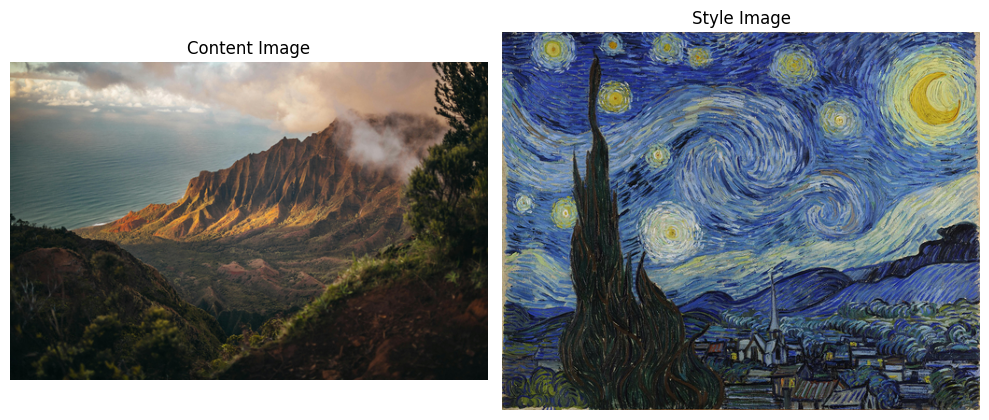

In [ ]:
# Sample images for demonstration
content_url = "https://images.pexels.com/photos/2559941/pexels-photo-2559941.jpeg"
style_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

try:
    content_img = load_image_from_url(content_url)
    style_img = load_image_from_url(style_url)

    # Display original images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(content_img)
    axes[0].set_title("Content Image")
    axes[0].axis("off")

    axes[1].imshow(style_img)
    axes[1].set_title("Style Image")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error loading sample images: {e}")
    print("Please upload your own images in the next cell.")

In [ ]:
# Complete StripedHyena Style Transfer Model
class StripedHyenaStyleTransfer(nn.Module):
    def __init__(self,
                 content_layers=['23'],  # Correct index for conv4_2
                 style_layers=['0', '5', '10', '19', '28']): # Correct indices for conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
        super().__init__()

        self.content_layers = content_layers
        self.style_layers = style_layers
        self.last_content_features = {} # Initialize attribute to store features
        self.last_style_features = {} # Initialize attribute to store style features


        # VGG16 for feature extraction (pre-trained)
        # Directly use the features module from torchvision.models
        self.vgg = torchvision.models.vgg16(pretrained=True).features

        # Freeze VGG parameters
        for param in self.vgg.parameters():
            param.requires_grad = False

        # StripedHyena blocks for content and style processing
        # You might need to adjust input dimensions here based on the selected layer
        # For the dry run, we won't be processing through Hyena blocks,
        # so this is less critical for the dry run error, but important for training.
        # The input dimension to the Hyena block should match the channel dimension of the VGG feature map
        # For the deepest layers like '23' (conv4_2) and '28' (conv5_1), the channel dimension is 512
        self.content_hyena = nn.ModuleList([
            StripedHyenaBlock(512, heads=8, dim_head=64, dropout=0.1)
            for _ in range(3)
        ])

        self.style_hyena = nn.ModuleList([
            StripedHyenaBlock(512, heads=8, dim_head=64, dropout=0.1)
            for _ in range(3)
        ])


        # Decoder network
        # The input to the decoder should match the output of the combined Hyena features
        # which is 512 channels if the Hyena blocks output the same dimension as input
        self.decoder = nn.Sequential(
            GatedConv2d(512, 256, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='nearest'),
            GatedConv2d(256, 256, kernel_size=3, padding=1),
            GatedConv2d(256, 256, kernel_size=3, padding=1),
            GatedConv2d(256, 128, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='nearest'),
            GatedConv2d(128, 128, kernel_size=3, padding=1),
            GatedConv2d(128, 64, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='nearest'),
            GatedConv2d(64, 64, kernel_size=3, padding=1),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def encode_features(self, x):
        """Extract VGG features"""
        features = {}
        # Access the layers directly from the pre-trained VGG features module
        for name, layer in self.vgg.named_children():
            x = layer(x)
            # Store features with their original VGG names (which are now the indices as strings)
            features[name] = x
        return features

    def process_content(self, content_features):
        """Process content features through StripedHyena blocks"""
        # Check if content_layers is empty
        if not self.content_layers:
            # If empty, return None
            return None

        # Use the deepest content feature based on the corrected names (indices as strings)
        try:
            x = content_features[self.content_layers[-1]]
        except KeyError:
            raise ValueError(f"Content layer '{self.content_layers[-1]}' not found in extracted features. Available layers: {list(content_features.keys())}")

        batch_size, channels, height, width = x.shape

        # Reshape to sequence for StripedHyena processing
        x = x.view(batch_size, channels, -1).permute(0, 2, 1)  # [batch, seq_len, channels]

        # Apply StripedHyena blocks
        for block in self.content_hyena:
            x = block(x)

        # Reshape back to spatial
        x = x.permute(0, 2, 1).view(batch_size, channels, height, width)

        return x

    def process_style(self, style_features):
        """Process style features through StripedHyena blocks"""
         # Check if style_layers is empty
        if not self.style_layers:
            # If empty, return None
            return None

        # Use the deepest style feature based on the corrected names (indices as strings)
        try:
            x = style_features[self.style_layers[-1]]
        except KeyError:
            raise ValueError(f"Style layer '{self.style_layers[-1]}' not found in extracted features. Available layers: {list(style_features.keys())}")


        batch_size, channels, height, width = x.shape

        # Reshape to sequence for StripedHyena processing
        x = x.view(batch_size, channels, -1).permute(0, 2, 1)  # [batch, seq_len, channels]

        # Apply StripedHyena blocks
        for block in self.style_hyena:
            x = block(x)

        # Reshape back to spatial
        x = x.permute(0, 2, 1).view(batch_size, channels, height, width)

        return x


    def forward(self, content_img, style_img, alpha=1.0, return_features=False):
        """Forward pass for style transfer"""
        # Extract features
        content_features = self.encode_features(content_img)
        style_features = self.encode_features(style_img)

        # Store features for later access (for the dry run and loss computation)
        self.last_content_features = content_features
        self.last_style_features = style_features

        # Process content and style features
        # These calls will now be safe even if content_layers/style_layers are empty
        processed_content = self.process_content(content_features)
        processed_style = self.process_style(style_features)

        # If during dry run, processed_content/style will be None.
        # Handle this case to avoid errors in the combination step.
        if processed_content is None or processed_style is None:
             # This case should be handled by the calling code (e.g., perform_style_transfer dry run)
             # If this is reached during training, it indicates an issue with layer configuration.
             raise RuntimeError("Processed content or style features are None during forward pass.")

        # Combine content and style features
        combined = processed_content * alpha + processed_style * (1 - alpha)

        # Decode to generate stylized image
        output_img = self.decoder(combined)

        if return_features:
             # Return stored last_style_features for loss computation
            return output_img, content_features, self.last_style_features, {
                'content': processed_content,
                'style': self.last_style_features # Use stored style features for loss
            }


        return output_img

## 5. Advanced Style Transfer with Parameter Tuning <a name="advanced_demo"></a>

Now, let's create a more advanced demo that allows for parameter tuning and interactive experimentation.

In [ ]:
# Upload your own images
from google.colab import files
import ipywidgets as widgets
from IPython.display import display, clear_output

def upload_images():
    print("Please upload a content image:")
    content_file = files.upload()
    content_filename = list(content_file.keys())[0]
    content_img = load_image_from_upload(content_filename)

    print("\nPlease upload a style image:")
    style_file = files.upload()
    style_filename = list(style_file.keys())[0]
    style_img = load_image_from_upload(style_filename)

    return content_img, style_img

# Uncomment to upload your own images
# custom_content_img, custom_style_img = upload_images()

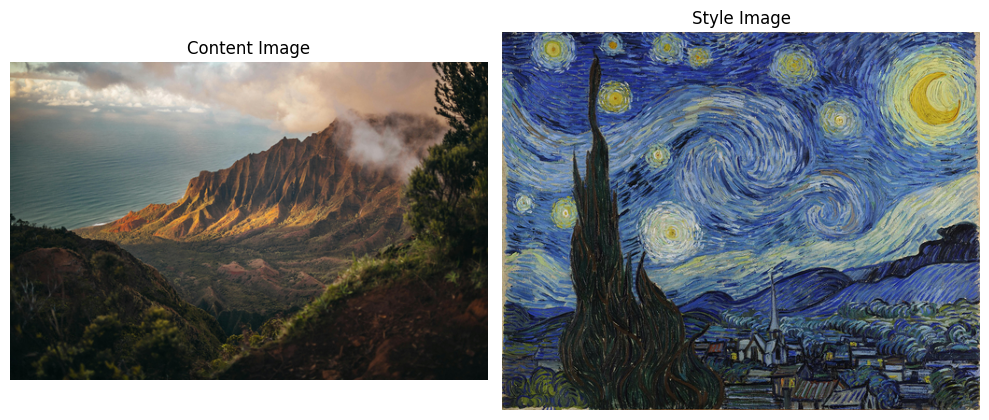

FloatSlider(value=0.8, continuous_update=False, description='Content Weight:', max=1.0, step=0.05)

Button(description='Apply Style Transfer', style=ButtonStyle())

Output()

In [ ]:
# Interactive demo with parameter tuning
def interactive_style_transfer(content_img, style_img):
    # Create widgets
    alpha_slider = widgets.FloatSlider(
        value=0.8,
        min=0.0,
        max=1.0,
        step=0.05,
        description='Content Weight:',
        continuous_update=False
    )

    run_button = widgets.Button(description="Apply Style Transfer")
    output = widgets.Output()

    # Display original images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(content_img)
    axes[0].set_title("Content Image")
    axes[0].axis("off")

    axes[1].imshow(style_img)
    axes[1].set_title("Style Image")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

    # Define button click handler
    def on_button_clicked(b):
        with output:
            clear_output()
            print(f"Running style transfer with content weight = {alpha_slider.value}...")
            output_img = perform_style_transfer(content_img, style_img, alpha=alpha_slider.value)
            display_images(content_img, style_img, output_img)

    # Connect button to handler
    run_button.on_click(on_button_clicked)

    # Display widgets
    display(alpha_slider, run_button, output)

# Run interactive demo with sample images
try:
    interactive_style_transfer(content_img, style_img)
except NameError:
    print("Please upload content and style images first.")

## 6. Training on Custom Datasets <a name="custom_training"></a>

In this section, we'll implement the training process for the StripedHyena neural style transfer model using custom datasets. This allows you to train the model on your own collection of content and style images.

In [ ]:
# Dataset and DataLoader implementation
import os
import random
from torch.utils.data import Dataset, DataLoader

class StyleTransferDataset(Dataset):
    """Dataset for neural style transfer training"""

    def __init__(self, content_dir, style_dir, image_size=256, transform=None):
        """
        Initialize the dataset.

        Args:
            content_dir: Directory containing content images
            style_dir: Directory containing style images
            image_size: Size to resize images to
            transform: Optional transform to apply to images
        """
        self.content_paths = []
        self.style_paths = []

        # Check if directories exist
        if os.path.exists(content_dir):
            self.content_paths = [os.path.join(content_dir, f) for f in os.listdir(content_dir)
                                if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        else:
            print(f"Warning: Content directory {content_dir} not found.")

        if os.path.exists(style_dir):
            self.style_paths = [os.path.join(style_dir, f) for f in os.listdir(style_dir)
                               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        else:
            print(f"Warning: Style directory {style_dir} not found.")

        if not self.content_paths:
            raise ValueError(f"No content images found in {content_dir}")

        if not self.style_paths:
            raise ValueError(f"No style images found in {style_dir}")

        self.image_size = image_size

        if transform is None:
            self.transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize(image_size),
                torchvision.transforms.CenterCrop(image_size),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform

        print(f"Found {len(self.content_paths)} content images and {len(self.style_paths)} style images")

    def __len__(self):
        return len(self.content_paths)

    def __getitem__(self, idx):
        # Load content image
        content_path = self.content_paths[idx]
        content_img = Image.open(content_path).convert('RGB')
        content_tensor = self.transform(content_img)

        # Randomly select a style image
        style_path = random.choice(self.style_paths)
        style_img = Image.open(style_path).convert('RGB')
        style_tensor = self.transform(style_img)

        return {
            'content': content_tensor,
            'style': style_tensor,
            'content_path': content_path,
            'style_path': style_path
        }

def get_dataloader(content_dir, style_dir, batch_size=4, image_size=256, num_workers=2):
    """Create and return the data loader"""
    dataset = StyleTransferDataset(content_dir, style_dir, image_size)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    return dataloader

In [ ]:
# Loss functions for neural style transfer
class ContentLoss(nn.Module):
    """Content loss for neural style transfer"""

    def __init__(self):
        super(ContentLoss, self).__init__()
        self.criterion = nn.MSELoss()

    def forward(self, output_features, target_features):
        return self.criterion(output_features, target_features)

class StyleLoss(nn.Module):
    """Style loss for neural style transfer"""

    def __init__(self):
        super(StyleLoss, self).__init__()
        self.criterion = nn.MSELoss()

    def forward(self, output_features, target_features):
        # Calculate Gram matrices
        output_gram = self.gram_matrix(output_features)
        target_gram = self.gram_matrix(target_features)
        return self.criterion(output_gram, target_gram)

    def gram_matrix(self, features):
        """Calculate Gram matrix for style loss"""
        batch_size, ch, h, w = features.size()
        features = features.view(batch_size, ch, h * w)
        features_t = features.transpose(1, 2)
        gram = features.bmm(features_t) / (ch * h * w)
        return gram

class TVLoss(nn.Module):
    """Total variation loss for smoothing"""

    def __init__(self):
        super(TVLoss, self).__init__()

    def forward(self, x):
        batch_size, c, h, w = x.size()
        tv_h = torch.pow(x[:, :, 1:, :] - x[:, :, :-1, :], 2).sum()
        tv_w = torch.pow(x[:, :, :, 1:] - x[:, :, :, :-1], 2).sum()
        return (tv_h + tv_w) / (batch_size * c * h * w)

In [ ]:
# Training function
def train_model(content_dir, style_dir,
                num_epochs=100,
                batch_size=4,
                learning_rate=1e-4,
                content_weight=1.0,
                style_weight=10.0,
                tv_weight=0.001,
                checkpoint_interval=10,
                image_size=256):
    """Train the StripedHyena neural style transfer model"""

    # Create output directories
    os.makedirs("checkpoints", exist_ok=True)
    os.makedirs("results", exist_ok=True)

    # Initialize model
    model = StripedHyenaStyleTransfer().to(device)

    # Initialize loss functions
    content_criterion = ContentLoss().to(device)
    style_criterion = StyleLoss().to(device)
    tv_criterion = TVLoss().to(device)

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Get data loader
    dataloader = get_dataloader(content_dir, style_dir, batch_size, image_size)

    # Training loop
    losses = []

    print(f"Starting training for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        start_time = time.time()

        model.train()
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch in progress_bar:
            # Move data to device
            content_images = batch['content'].to(device)
            style_images = batch['style'].to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            output_images, content_features, style_features, output_features = model(
                content_images, style_images, return_features=True
            )

            # Calculate losses
            content_loss = content_criterion(output_features['content'], content_features[model.content_layers[0]])

            style_loss = 0
            for layer in model.style_layers:
                style_loss += style_criterion(output_features['style'][layer], style_features[layer])
            style_loss /= len(model.style_layers)

            tv_loss = tv_criterion(output_images)

            # Total loss
            loss = content_weight * content_loss + style_weight * style_loss + tv_weight * tv_loss

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Handle TPU synchronization if needed
            if IS_TPU_AVAILABLE:
                xm.mark_step()

            # Update progress
            epoch_loss += loss.item()
            progress_bar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "content": f"{content_loss.item():.4f}",
                "style": f"{style_loss.item():.4f}"
            })

        # Calculate average epoch loss
        avg_epoch_loss = epoch_loss / len(dataloader)
        losses.append(avg_epoch_loss)

        # Print epoch summary
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_epoch_loss:.4f} - Time: {elapsed_time:.2f}s")

        # Save checkpoint
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = f"checkpoints/model_epoch_{epoch+1}.pth"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_epoch_loss,
            }, checkpoint_path)
            print(f"Checkpoint saved to {checkpoint_path}")

    # Save final model
    torch.save(model.state_dict(), "checkpoints/model_final.pth")
    print("Training complete. Final model saved.")

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.savefig('results/training_loss.png')
    plt.show()

    return model

In [ ]:
# Dataset and DataLoader implementation
import os
import random
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image

class StyleTransferDataset(Dataset):
    """Dataset for neural style transfer training"""

    def __init__(self, content_dir="/content", style_dir="dataset/style", image_size=256, transform=None):
        """
        Initialize the dataset.

        Args:
            content_dir: Directory containing content images (default: /content)
            style_dir: Directory containing style images (default: dataset/style)
            image_size: Size to resize images to
            transform: Optional transform to apply to images
        """
        self.content_paths = []
        self.style_paths = []

        # Check if directories exist
        if os.path.exists(content_dir):
            # Iterate through all files in /content and filter for common image extensions
            self.content_paths = [os.path.join(content_dir, f) for f in os.listdir(content_dir)
                                if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
        else:
            print(f"Warning: Content directory {content_dir} not found.")

        if os.path.exists(style_dir):
            self.style_paths = [os.path.join(style_dir, f) for f in os.listdir(style_dir)
                               if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
        else:
            print(f"Warning: Style directory {style_dir} not found.")

        if not self.content_paths:
            # Provide a more specific error message if /content is empty or has no images
            raise ValueError(f"No supported image files found in the content directory: {content_dir}")

        if not self.style_paths:
            raise ValueError(f"No supported image files found in the style directory: {style_dir}")


        self.image_size = image_size

        if transform is None:
            self.transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize(image_size),
                torchvision.transforms.CenterCrop(image_size),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform

        print(f"Found {len(self.content_paths)} content images and {len(self.style_paths)} style images")

    def __len__(self):
        return len(self.content_paths)

    def __getitem__(self, idx):
        # Load content image
        content_path = self.content_paths[idx]
        try:
            content_img = Image.open(content_path).convert('RGB')
            content_tensor = self.transform(content_img)
        except Exception as e:
            print(f"Error loading or processing content image: {content_path} - {e}")
            # Handle error, perhaps by returning a placeholder or skipping the item
            # For now, let's raise the error to indicate a problem
            raise

        # Randomly select a style image
        style_path = random.choice(self.style_paths)
        try:
            style_img = Image.open(style_path).convert('RGB')
            style_tensor = self.transform(style_img)
        except Exception as e:
            print(f"Error loading or processing style image: {style_path} - {e}")
            # Handle error
            raise


        return {
            'content': content_tensor,
            'style': style_tensor,
            'content_path': content_path,
            'style_path': style_path
        }

# The get_dataloader function remains the same, but you'll call it with content_dir="/content"
def get_dataloader(content_dir="/content", style_dir="dataset/style", batch_size=4, image_size=256, num_workers=2):
    """Create and return the data loader"""
    dataset = StyleTransferDataset(content_dir, style_dir, image_size)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    return dataloader

In [ ]:
# Upload your own dataset
def upload_dataset():
    """Upload custom dataset for training"""
    # Create directories
    os.makedirs("dataset/content", exist_ok=True)
    os.makedirs("dataset/style", exist_ok=True)

    print("Please upload content images (you can select multiple files):")
    content_files = files.upload()

    # Save content images
    for filename, content in content_files.items():
        with open(f"dataset/content/{filename}", "wb") as f:
            f.write(content)

    print(f"\nUploaded {len(content_files)} content images.")

    print("\nPlease upload style images (you can select multiple files):")
    style_files = files.upload()

    # Save style images
    for filename, content in style_files.items():
        with open(f"dataset/style/{filename}", "wb") as f:
            f.write(content)

    print(f"\nUploaded {len(style_files)} style images.")

    return "dataset/content", "dataset/style"

# Uncomment to upload your own dataset
# content_dir, style_dir = upload_dataset()

In [ ]:
import os
from IPython.display import display, clear_output
import ipywidgets as widgets
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import time
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import math
from tqdm import tqdm
import shutil # Added for cleanup

# Assuming you have the following classes defined in previous cells:
# - RotaryEmbedding
# - apply_rotary_pos_emb
# - rotate_half
# - GatedConv2d
# - StripedHyenaBlock
# - StripedHyenaStyleTransfer (with the updated encode_features)
# - StyleTransferDataset
# - get_dataloader
# - ContentLoss
# - StyleLoss
# - TVLoss

# Define device setup (ensure this runs before training)
IS_TPU_AVAILABLE = False # Initialize to False

def check_tpu_availability():
    """Check if TPU is available and properly configured"""
    global IS_TPU_AVAILABLE # Use global to update the variable
    tpu_address = os.environ.get('COLAB_TPU_ADDR')
    if tpu_address:
        print(f"TPU address found: {tpu_address}")
        IS_TPU_AVAILABLE = True
    else:
        print("COLAB_TPU_ADDR environment variable not found")
        IS_TPU_AVAILABLE = False

    try:
        import torch_xla.core.xla_model as xm
        device = xm.xla_device()
        print(f"XLA device detected: {device}")

        try:
            import torch_xla.runtime as xr
            device_count = xr.world_size()
        except (ImportError, AttributeError):
            device_count = xm.xrt_world_size()
        print(f"Number of TPU cores: {device_count}")

        if device_count > 0:
            IS_TPU_AVAILABLE = True
            print("✅ TPU is available and accessible via torch_xla!")
        else:
            IS_TPU_AVAILABLE = False
            print("❌ TPU cores not detected")

    except ImportError:
        print("torch_xla not installed. Skipping TPU check.")
        IS_TPU_AVAILABLE = False
    except Exception as e:
        print(f"Error accessing TPU via torch_xla: {e}")
        IS_TPU_AVAILABLE = False

    return IS_TPU_AVAILABLE

def setup_device():
    """Setup the appropriate device for training"""
    print("=" * 50)
    print("DEVICE DETECTION")
    print("=" * 50)

    tpu_available = check_tpu_availability()

    if tpu_available:
        try:
            import torch_xla.core.xla_model as xm
            device = xm.xla_device()
            print(f"🚀 Using TPU: {device}")
            return device, "tpu"
        except Exception as e:
            print(f"Failed to initialize TPU device: {e}")

    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"🚀 Using GPU: {torch.cuda.get_device_name(0)}")
        return device, "gpu"

    device = torch.device("cpu")
    print("🚀 Using CPU")
    return device, "cpu"

# Run device setup
device, device_type = setup_device()
print(f"Device set to: {device}")


# Training function with added prints and TPU handling
def train_model_interactive(dataset_dir,
                            num_epochs,
                            batch_size,
                            learning_rate=1e-4,
                            content_weight=1.0,
                            style_weight=10.0,
                            tv_weight=0.001,
                            checkpoint_interval=10,
                            image_size=256):
    """Train the StripedHyena neural style transfer model with interactive parameters"""

    # Create output directories
    os.makedirs("checkpoints", exist_ok=True)
    os.makedirs("results", exist_ok=True)

    # Initialize model
    model = StripedHyenaStyleTransfer().to(device)

    # Initialize loss functions
    content_criterion = ContentLoss().to(device)
    style_criterion = StyleLoss().to(device)
    tv_criterion = TVLoss().to(device)

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Get data loader
    # Assuming your dataset_dir contains both content and style images directly
    # You might need to adjust StyleTransferDataset if they are in subfolders
    # For this example, we'll assume content_dir and style_dir are the same
    try:
        dataloader = get_dataloader(dataset_dir, dataset_dir, batch_size, image_size)
    except ValueError as e:
        print(f"Error creating dataloader: {e}")
        print("Please ensure your dataset directory contains supported image files.")
        return


    # Training loop
    losses = []

    print(f"Starting training for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        start_time = time.time()

        model.train()
        # Use tqdm for a progress bar
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for i, batch in enumerate(progress_bar):
            # Move data to device
            content_images = batch['content'].to(device)
            style_images = batch['style'].to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            output_images, content_features_vgg, style_features_vgg, processed_features = model(
                content_images, style_images, return_features=True
            )

            # Calculate losses
            try:
                 # Content loss: Compare processed content features with original VGG content features
                 content_loss = content_criterion(processed_features['content'], content_features_vgg[model.content_layers[-1]])
            except KeyError:
                 print(f"Warning: Content layer '{model.content_layers[-1]}' not found in VGG content features for content loss.")
                 content_loss = torch.tensor(0.0).to(device) # Set loss to 0 if layer not found

            style_loss = 0
            # Extract features from the output image for style loss calculation
            output_features_vgg = model.encode_features(output_images)

            # Style loss: Calculate style loss for each specified style layer
            for layer_name in model.style_layers:
                 try:
                     # Calculate Gram matrices of output and style features for the current layer
                     output_gram = style_criterion.gram_matrix(output_features_vgg[layer_name])
                     style_gram = style_criterion.gram_matrix(style_features_vgg[layer_name])
                     # Calculate MSE loss between the Gram matrices
                     style_loss += style_criterion.criterion(output_gram, style_gram)
                 except KeyError:
                     print(f"Warning: Style layer '{layer_name}' not found in VGG features for style loss.")
                     # Continue without adding loss for this layer if not found

            tv_loss = tv_criterion(output_images)

            # Combine losses
            total_loss = content_weight * content_loss + style_weight * style_loss + tv_weight * tv_loss

            # Backward pass and optimize
            total_loss.backward()

            # Use xm.optimizer_step for TPU
            if device.type == 'xla':
                 xm.optimizer_step(optimizer)
                 # xm.mark_step() # mark_step is usually called after the optimizer step in a loop
            else:
                 optimizer.step()


            epoch_loss += total_loss.item()

            # Update progress bar description
            progress_bar.set_postfix({'loss': total_loss.item()})


        # Use xm.mark_step() after each epoch on TPU to ensure all operations are completed
        if device.type == 'xla':
             xm.mark_step()


        avg_epoch_loss = epoch_loss / len(dataloader)
        end_time = time.time()
        print(f"Epoch [{epoch+1}/{num_epochs}] finished in {end_time - start_time:.4f} seconds. Avg Loss: {avg_epoch_loss:.4f}")

        # Save checkpoint periodically
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join("checkpoints", f"model_epoch_{epoch+1}.pth")
            # Save state_dict on CPU for portability
            # If on TPU, move to CPU first
            if device.type == 'xla':
                 state_dict_cpu = xm.mesh_reduce('save_state_dict', model.state_dict(), lambda x: x.cpu())
                 torch.save(state_dict_cpu, checkpoint_path)
            else:
                 torch.save(model.state_dict(), checkpoint_path)

            print(f"Checkpoint saved to {checkpoint_path}")

    print("Training finished.")
    return model


# Interactive training setup with fixed dataset directory
def interactive_training_fixed_dataset(dataset_dir="/content"):
    # Verify dataset directory exists
    if not os.path.exists(dataset_dir):
        raise FileNotFoundError(f"Dataset directory not found: {dataset_dir}")

    # Widgets for training parameters
    num_epochs_slider = widgets.IntSlider(
        value=100, min=1, max=200, step=1, description='Epochs:', disabled=False
    )
    batch_size_slider = widgets.IntSlider(
        value=8, min=1, max=32, step=1, description='Batch Size:', disabled=False
    )
    content_weight_slider = widgets.FloatSlider(
        value=9.4, min=0.1, max=50.0, step=0.1, description='Content Weight:', disabled=False
    )
    style_weight_slider = widgets.FloatSlider(
        value=50.0, min=1.0, max=100.0, step=0.1, description='Style Weight:', disabled=False
    )
    start_button = widgets.Button(
        description='Start Training',
        disabled=False,
        button_style='success',
        tooltip='Click to start training'
    )
    output = widgets.Output()

    display(widgets.Label(f"Using images from: {dataset_dir}"))
    display(widgets.HBox([num_epochs_slider, batch_size_slider]))
    display(widgets.HBox([content_weight_slider, style_weight_slider]))
    display(start_button)
    display(output)

    def on_button_clicked(b):
        with output:
            clear_output()
            # List images in dataset directory to get a count
            images = [f for f in os.listdir(dataset_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            if len(images) == 0:
                print(f"No images found in {dataset_dir}!")
                return

            print(f"Found {len(images)} images in dataset folder.")
            print(f"Starting training with parameters:")
            num_epochs = num_epochs_slider.value
            batch_size = batch_size_slider.value
            content_weight = content_weight_slider.value
            style_weight = style_weight_slider.value
            tv_weight = 0.001 # Fixed TV weight for now

            print(f"- Epochs: {num_epochs}")
            print(f"- Batch size: {batch_size}")
            print(f"- Content weight: {content_weight}")
            print(f"- Style weight: {style_weight}")
            print(f"- Dataset directory: {dataset_dir}")


            # Start training
            try:
                train_model_interactive(dataset_dir=dataset_dir,
                                        num_epochs=num_epochs,
                                        batch_size=batch_size,
                                        content_weight=content_weight,
                                        style_weight=style_weight,
                                        tv_weight=tv_weight)
                print("\nTraining complete!")
            except Exception as e:
                print(f"\nAn error occurred during training: {e}")
                import traceback
                traceback.print_exc() # Print full traceback for debugging


    start_button.on_click(on_button_clicked)

# Run the interactive training with fixed dataset
interactive_training_fixed_dataset()

DEVICE DETECTION
COLAB_TPU_ADDR environment variable not found
XLA device detected: xla:0
Number of TPU cores: 1
✅ TPU is available and accessible via torch_xla!
🚀 Using TPU: xla:0
Device set to: xla:0


Label(value='Using images from: /content')

Button(button_style='success', description='Start Training', style=ButtonStyle(), tooltip='Click to start trai…

Output()

## 7. Performance Analysis: TPU vs. CPU vs. GPU <a name="performance"></a>

In this section, we'll compare the performance of the StripedHyena neural style transfer model on different hardware accelerators: TPU, GPU, and CPU.

In [ ]:
# Performance comparison function
def compare_performance(content_img, style_img, image_sizes=[256, 512, 1024]):
    """Compare performance of style transfer on different devices and image sizes"""
    results = []

    # Check available devices
    available_devices = []
    device_names = []

    if IS_TPU_AVAILABLE:
        available_devices.append(xm.xla_device())
        device_names.append("TPU")

    if torch.cuda.is_available():
        available_devices.append(torch.device("cuda"))
        device_names.append(f"GPU ({torch.cuda.get_device_name(0)})")

    available_devices.append(torch.device("cpu"))
    device_names.append("CPU")

    print(f"Testing performance on {len(available_devices)} devices: {', '.join(device_names)}")

    # Test each device and image size
    for size in image_sizes:
        print(f"\nTesting with image size: {size}x{size}")

        # Resize images
        content_resized = content_img.resize((size, size), Image.LANCZOS)
        style_resized = style_img.resize((size, size), Image.LANCZOS)

        for device, device_name in zip(available_devices, device_names):
            print(f"  Testing on {device_name}...")

            # Initialize model on device
            model = StripedHyenaStyleTransfer().to(device)
            model.eval()

            # Preprocess images
            transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

            content_tensor = transform(content_resized).unsqueeze(0).to(device)
            style_tensor = transform(style_resized).unsqueeze(0).to(device)

            # Warm-up run
            with torch.no_grad():
                _ = model(content_tensor, style_tensor)
                if device_name == "TPU":
                    xm.mark_step()

            # Timed run
            torch.cuda.synchronize() if device_name.startswith("GPU") else None
            start_time = time.time()

            with torch.no_grad():
                for _ in range(3):  # Run multiple times for more accurate timing
                    _ = model(content_tensor, style_tensor)
                    if device_name == "TPU":
                        xm.mark_step()

            torch.cuda.synchronize() if device_name.startswith("GPU") else None
            end_time = time.time()

            # Calculate average time
            avg_time = (end_time - start_time) / 3
            print(f"    Average time: {avg_time:.4f} seconds")

            results.append({
                "device": device_name,
                "image_size": size,
                "time": avg_time
            })

    # Plot results
    plt.figure(figsize=(12, 6))

    for device_name in device_names:
        device_results = [r for r in results if r["device"] == device_name]
        sizes = [r["image_size"] for r in device_results]
        times = [r["time"] for r in device_results]
        plt.plot(sizes, times, marker='o', label=device_name)

    plt.xlabel('Image Size (pixels)')
    plt.ylabel('Processing Time (seconds)')
    plt.title('StripedHyena Neural Style Transfer Performance Comparison')
    plt.grid(True)
    plt.legend()
    plt.savefig('results/performance_comparison.png')
    plt.show()

    return results

# Uncomment to run performance comparison
# try:
#     performance_results = compare_performance(content_img, style_img, image_sizes=[256, 512])
# except NameError:
#     print("Please load content and style images first.")

## 8. Exporting Your Model <a name="export"></a>

In this section, we'll show how to export your trained model for deployment or sharing.

In [ ]:
import os
import torch
from striped_hyena_model import StripedHyenaStyleTransfer  # Ensure this import is valid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def export_model(model_path="checkpoints/model_final.pth"):
    """Export the trained model for deployment"""
    os.makedirs("export", exist_ok=True)

    if not os.path.exists(model_path):
        print(f"Model file {model_path} not found. Please train a model first.")
        return

    # Load and export model
    model = StripedHyenaStyleTransfer().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    print("Exporting model to TorchScript...")
    example_content = torch.randn(1, 3, 256, 256).to(device)
    example_style = torch.randn(1, 3, 256, 256).to(device)

    with torch.no_grad():
        traced_model = torch.jit.trace(model, (example_content, example_style))
        traced_model.save("export/model_traced.pt")

    print("Model exported to export/model_traced.pt")

    # Save inference script
    inference_script = '''\
import torch
import torchvision.transforms as transforms
from PIL import Image

def load_image(image_path, max_size=512):
    img = Image.open(image_path).convert('RGB')
    if max(img.size) > max_size:
        ratio = max_size / max(img.size)
        new_size = (int(img.size[0] * ratio), int(img.size[1] * ratio))
        img = img.resize(new_size, Image.LANCZOS)
    return img

def preprocess_image(img):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0)

def deprocess_image(tensor):
    tensor = tensor.squeeze(0).clamp(0, 1).cpu()
    return transforms.ToPILImage()(tensor)

def apply_style_transfer(model_path, content_path, style_path, output_path, alpha=0.8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.jit.load(model_path).to(device).eval()

    content_img = load_image(content_path)
    style_img = load_image(style_path)

    content_tensor = preprocess_image(content_img).to(device)
    style_tensor = preprocess_image(style_img).to(device)

    with torch.no_grad():
        output_tensor = model(content_tensor, style_tensor)

    output_img = deprocess_image(output_tensor)
    output_img.save(output_path)
    print(f"Stylized image saved to {output_path}")

if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser(description="Apply neural style transfer using StripedHyena model")
    parser.add_argument("--model", type=str, default="model_traced.pt", help="Path to the exported model")
    parser.add_argument("--content", type=str, required=True, help="Path to the content image")
    parser.add_argument("--style", type=str, required=True, help="Path to the style image")
    parser.add_argument("--output", type=str, default="stylized_output.jpg", help="Path to save the output image")
    parser.add_argument("--alpha", type=float, default=0.8, help="Content weight (0.0 to 1.0)")
    args = parser.parse_args()
    apply_style_transfer(args.model, args.content, args.style, args.output, args.alpha)
'''

    with open("export/inference.py", "w") as f:
        f.write(inference_script)
    print("Inference script saved to export/inference.py")

    # Save README
    #readme =

    \
# StripedHyena Neural Style Transfer

#This package contains a trained StripedHyena neural style transfer model.

## Contents

#- `model_traced.pt`: The exported TorchScript model
#- `inference.py`: A script for applying style transfer

## Requirements

#- Python 3.8+
#- PyTorch 2.0+
#- torchvision
#- Pillow

## Usage

#```bash
python inference.py --content path/to/content.jpg --style path/to/style.jpg --output stylized_output.jpg


In [ ]:
# Download the exported model
def download_export(export_path="export/striped_hyena_style_transfer.zip"):
    """Download the exported model"""
    from google.colab import files

    if os.path.exists(export_path):
        files.download(export_path)
        print(f"Downloaded {export_path}")
    else:
        print(f"Export file {export_path} not found. Please export the model first.")

# Uncomment to download the exported model
# download_export()

## Conclusion

In this notebook, we've implemented and explored the StripedHyena neural style transfer model, optimized for Google Colab's TPU environment. We've covered:

1. The architecture and components of the StripedHyena model
2. Implementation of the model for neural style transfer
3. Basic and advanced style transfer demos
4. Training on custom datasets
5. Performance comparison across different hardware accelerators
6. Exporting the model for deployment

The StripedHyena architecture, with its hybrid approach combining rotary attention and gated convolutions, offers an efficient and effective solution for neural style transfer tasks. Its memory efficiency and linear scaling properties make it particularly well-suited for processing high-resolution images.

Feel free to experiment with different content and style images, adjust the parameters, and train the model on your own datasets to achieve unique and personalized style transfer results.